# LOADING PACKAGES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, levene, ttest_ind, kruskal, shapiro
import pprint
import scipy.stats as stats
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm

In [2]:
path = "D://TRAININGS//FORMATION RISK//SCORE OCTROI//data//"

data = pd.read_csv(path+'data.csv')
data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000.0,2,2,1,24,Late_payment,Late_payment,Pay_duly,Pay_duly,Pay_duly,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,Pay_duly,Late_payment,Pay_duly,Pay_duly,Pay_duly,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,Pay_duly,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,Pay_duly,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,Pay_duly,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,Pay_duly,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,150000.0,1,3,2,43,Pay_duly,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,30000.0,1,2,2,37,Late_payment,Late_payment,Late_payment,Pay_duly,Pay_duly,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,80000.0,1,3,1,41,Late_payment,Pay_duly,Pay_duly,Pay_duly,Pay_duly,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


# FEATURE SELECTION

In [3]:
X = data.drop("DEFAULT", axis=1)
y = data.DEFAULT

categorial_vars = X.select_dtypes(include=['object'])
numeric_vars = X.select_dtypes(include=['number'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train[categorial_vars.columns] = X_train[categorial_vars.columns].astype(str)
X_test[categorial_vars.columns] = X_test[categorial_vars.columns].astype(str)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorial_vars.columns)  # One-hot encoding pour les colonnes catégorielles
    ],
    remainder='passthrough'  # Laisser les autres colonnes inchangées
)

In [4]:
# Transformer les variables catégorielles avec OneHotEncoder et garder les autres variables inchangées
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
X_train_transformed

array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 6.000e+03, 6.000e+03,
        5.500e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 2.846e+03,
        1.936e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.600e+03, 1.600e+03,
        1.600e+03],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.000e+03, 1.200e+03,
        1.000e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [5]:
# Récupérer les noms des nouvelles colonnes créées par OneHotEncoder
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorial_vars.columns)
# Fusionner avec les colonnes numériques originales
new_columns = list(onehot_columns) + list(X_train.select_dtypes(exclude=['object', 'category']).columns)
# Afficher les nouveaux noms de colonnes
new_columns

['EDUCATION_2',
 'EDUCATION_3',
 'EDUCATION_Other',
 'MARRIAGE_2',
 'MARRIAGE_Other',
 'PAY_0_Pay_duly',
 'PAY_2_Pay_duly',
 'PAY_3_Pay_duly',
 'PAY_4_Pay_duly',
 'PAY_5_Pay_duly',
 'PAY_6_Pay_duly',
 'LIMIT_BAL',
 'SEX',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [6]:
# Convertir en DataFrame avec les nouveaux noms de colonnes
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=new_columns, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=new_columns, index=X_test.index)

# Afficher les premières lignes du DataFrame transformé
X_train_transformed_df.head()

,EDUCATION_2,EDUCATION_3,EDUCATION_Other,MARRIAGE_2,MARRIAGE_Other,PAY_0_Pay_duly,PAY_2_Pay_duly,PAY_3_Pay_duly,PAY_4_Pay_duly,PAY_5_Pay_duly,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
11018,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,155404.0,153234.0,156731.0,155818.0,6000.0,6000.0,5600.0,6000.0,6000.0,5500.0
1710,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,42283.0,51539.0,50583.0,52588.0,5000.0,10000.0,10000.0,0.0,2846.0,1936.0
4618,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,64277.0,45455.0,42231.0,42804.0,3300.0,2500.0,1556.0,1600.0,1600.0,1600.0
5482,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,780.0,0.0,0.0,0.0,1006.0,780.0,0.0,0.0,0.0,0.0
26187,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,2070.0,0.0,0.0,0.0,0.0,0.0


# MODELS TRAINING

## LOGISTIC REGRESSION

In [7]:
import statsmodels.api as sm
# Ajouter une constante pour l'interception
X_train_model = sm.add_constant(X_train_transformed_df)
X_train_model

,const,EDUCATION_2,EDUCATION_3,EDUCATION_Other,MARRIAGE_2,MARRIAGE_Other,PAY_0_Pay_duly,PAY_2_Pay_duly,PAY_3_Pay_duly,PAY_4_Pay_duly,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
11018,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,155404.0,153234.0,156731.0,155818.0,6000.0,6000.0,5600.0,6000.0,6000.0,5500.0
1710,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,42283.0,51539.0,50583.0,52588.0,5000.0,10000.0,10000.0,0.0,2846.0,1936.0
4618,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,64277.0,45455.0,42231.0,42804.0,3300.0,2500.0,1556.0,1600.0,1600.0,1600.0
5482,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,780.0,0.0,0.0,0.0,1006.0,780.0,0.0,0.0,0.0,0.0
26187,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,2070.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13921,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,115515.0,113948.0,122127.0,121962.0,4200.0,4100.0,4100.0,10000.0,4560.0,0.0
3794,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,67187.0,49924.0,33188.0,19826.0,3700.0,2023.0,2016.0,2000.0,1200.0,1000.0
27565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,860.0,246.0,-46.0,-46.0,0.0,860.0,246.0,0.0,0.0,0.0


In [8]:
# Créer le modèle de régression logistique
logit_model = sm.Logit(y_train, X_train_model)

# Ajuster le modèle aux données d'apprentissage
result = logit_model.fit()

# Afficher le résumé des résultats de la régression
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.444681
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                DEFAULT   No. Observations:                21000
Model:                          Logit   Df Residuals:                    20973
Method:                           MLE   Df Model:                           26
Date:                Wed, 26 Mar 2025   Pseudo R-squ.:                  0.1585
Time:                        19:08:33   Log-Likelihood:                -9338.3
converged:                       True   LL-Null:                       -11097.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4823      0.133     11.124      0.000       1.221       1.743
EDUCATION_2   

#### Commentaires : 
LLR p-value = 0, les variables du modèles permettent d'expliquer la variable çà prédire
Les coefficients positifs montrent que certaines variables augmentent les chances de faire défaut et inversément pour les variables dont les oefficients sont négatifs (faire attention à la variable LIMIT_BAL qui a un coefficient négatif, intuitivement cela n'est pas possible)
Les variables dont la p-value est >5% ne sont pas statistiquement significatives dans le modèle
Les coefficients qui ne sont pas cohérents le sont probablement du fait de la colinéarité entre les variables, il convient d'utiliser les métriques comme le VIF afin de déterminer l'impact de la colinéarité

In [9]:
"""
# Calcul du VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculer le VIF pour chaque variable
vif = pd.DataFrame()
vif["Variable"] = X_train_transformed_df.columns
vif["VIF"] = [variance_inflation_factor(X_train_transformed_df.values, i) for i in range(X_train_transformed_df.shape[1])]

# Afficher le DataFrame VIF
vif
"""

'\n# Calcul du VIF\nfrom statsmodels.stats.outliers_influence import variance_inflation_factor\n\n# Calculer le VIF pour chaque variable\nvif = pd.DataFrame()\nvif["Variable"] = X_train_transformed_df.columns\nvif["VIF"] = [variance_inflation_factor(X_train_transformed_df.values, i) for i in range(X_train_transformed_df.shape[1])]\n\n# Afficher le DataFrame VIF\nvif\n'

**Comment :** On remarque que les VIFs des variables BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6 sont très élevés (probable problème de colinéarité)

In [10]:
"""
X_train_transformed_df1 = X_train_transformed_df.drop(['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], axis=1)
X_train_model = sm.add_constant(X_train_transformed_df1)
X_train_model
# Créer le modèle de régression logistique
logit_model1 = sm.Logit(y_train, X_train_model)

# Ajuster le modèle aux données d'apprentissage
result = logit_model1.fit()

# Afficher le résumé des résultats de la régression
print(result.summary())
"""

"\nX_train_transformed_df1 = X_train_transformed_df.drop(['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], axis=1)\nX_train_model = sm.add_constant(X_train_transformed_df1)\nX_train_model\n# Créer le modèle de régression logistique\nlogit_model1 = sm.Logit(y_train, X_train_model)\n\n# Ajuster le modèle aux données d'apprentissage\nresult = logit_model1.fit()\n\n# Afficher le résumé des résultats de la régression\nprint(result.summary())\n"

In [11]:
def evaluer_performance(y_true, y_pred_prob, set_name="test", seuil=0.5):
    """
    Fonction pour évaluer les performances d'un modèle sur un ensemble donné (entraînement ou test).

    Paramètres:
    - y_true: Labels réels de l'ensemble évalué
    - y_pred_prob: Probabilités prédites par le modèle sur l'ensemble évalué (valeurs continues)
    - set_name: Nom de l'ensemble évalué ('train' ou 'test')
    - seuil: Seuil de décision pour convertir les probabilités en prédictions binaires (par défaut 0.5)

    Retourne:
    - Les métriques de performance, la matrice de confusion sous forme de tableau et une heatmap, ainsi que la courbe ROC
    """
    # Convertir les probabilités en prédictions binaires avec le seuil spécifié
    y_pred = (y_pred_prob >= seuil).astype(int)

    # Calcul des métriques de performance
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Affichage des métriques
    print(f"Métriques sur l'ensemble {set_name}:")
    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)

    # Affichage de la matrice de confusion sous forme de tableau
    cm_df = pd.DataFrame(cm, index=["Négatif (0)", "Positif (1)"], columns=["Prédiction Négatif (0)", "Prédiction Positif (1)"])
    print("\nMatrice de Confusion (tableau):")
    print(cm_df)

    # Affichage de la matrice de confusion sous forme de heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Négatif", "Positif"], yticklabels=["Négatif", "Positif"])
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies valeurs')
    plt.title(f"Matrice de Confusion - {set_name}")
    plt.show()

    # Calcul des courbes ROC avec les valeurs continues des probabilités
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Affichage de l'AUC
    print(f"AUC: {roc_auc:.2f}")

    # Tracer la courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - {set_name}')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
# Prédiction
y_train_pred = result.predict(X_train_model)
y_train_pred

11018    0.123778
1710     0.152511
4618     0.159456
5482     0.164349
26187    0.142082
           ...   
25780    0.128589
13921    0.178758
3794     0.136703
27565    0.342745
27126    0.127520
Length: 21000, dtype: float64

In [13]:
# Ajouter une constante pour l'interception
X_test_model = sm.add_constant(X_test_transformed_df)
X_test_model

,const,EDUCATION_2,EDUCATION_3,EDUCATION_Other,MARRIAGE_2,MARRIAGE_Other,PAY_0_Pay_duly,PAY_2_Pay_duly,PAY_3_Pay_duly,PAY_4_Pay_duly,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
8941,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,84297.0,49681.0,46224.0,44800.0,5000.0,4000.0,2029.0,2000.0,2500.0,1300.0
17618,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,3342.0,4844.0,3728.0,2612.0,0.0,0.0,4844.0,0.0,0.0,0.0
27895,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,77303.0,60178.0,56436.0,51773.0,70001.0,3769.0,2008.0,1950.0,2001.0,18000.0
16103,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2440.0,2510.0,2641.0,2222.0,0.0,0.0,500.0,400.0,0.0,36.0
4422,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,27012.0,27762.0,32126.0,37779.0,2000.0,2000.0,1500.0,5000.0,6400.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27933,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,176081.0,175540.0,142015.0,139162.0,6500.0,7000.0,7200.0,5018.0,5200.0,5300.0
26623,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,12905.0,13498.0,13993.0,13854.0,1502.0,1522.0,1505.0,1000.0,1000.0,1000.0
21750,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,3308.0,2527.0,1076.0,1164.0,0.0,3308.0,2527.0,1079.0,1167.0,1974.0
14888,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
y_test_pred = result.predict(X_test_model)
y_test_pred

8941     0.125223
17618    0.240803
27895    0.079924
16103    0.486720
4422     0.145367
           ...   
27933    0.125313
26623    0.152504
21750    0.121936
14888    0.274600
20705    0.171026
Length: 9000, dtype: float64

Métriques sur l'ensemble train:
Accuracy: 0.81, Precision: 0.64, Recall: 0.30, F1: 0.41

Matrice de Confusion (tableau):
             Prédiction Négatif (0)  Prédiction Positif (1)
Négatif (0)                   15574                     781
Positif (1)                    3230                    1415


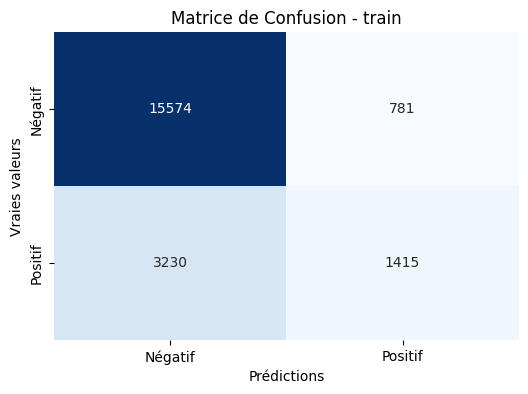

AUC: 0.76


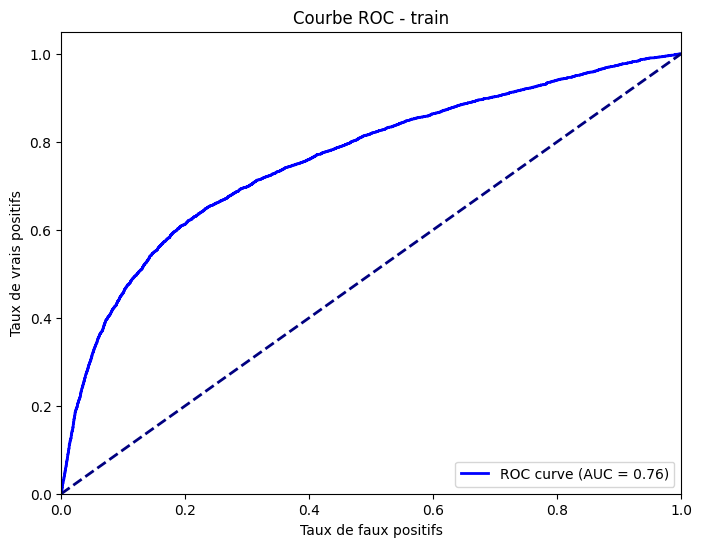

In [15]:
# Évaluer les performances sur l'ensemble d'entraînement
evaluer_performance(y_train, y_train_pred, set_name="train")

Métriques sur l'ensemble test:
Accuracy: 0.80, Precision: 0.63, Recall: 0.29, F1: 0.39

Matrice de Confusion (tableau):
             Prédiction Négatif (0)  Prédiction Positif (1)
Négatif (0)                    6665                     344
Positif (1)                    1417                     574


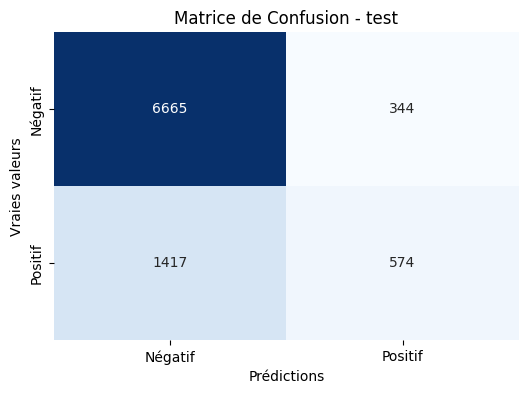

AUC: 0.75


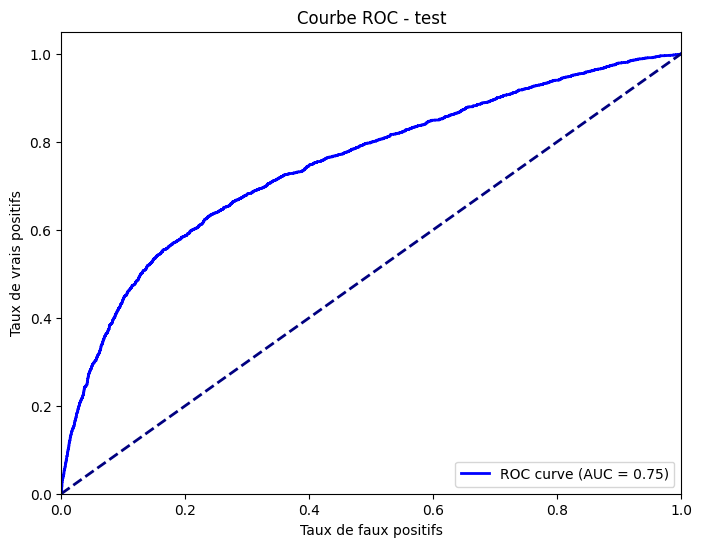

In [16]:
# Évaluer les performances sur l'ensemble de test
evaluer_performance(y_test, y_test_pred, set_name="test")

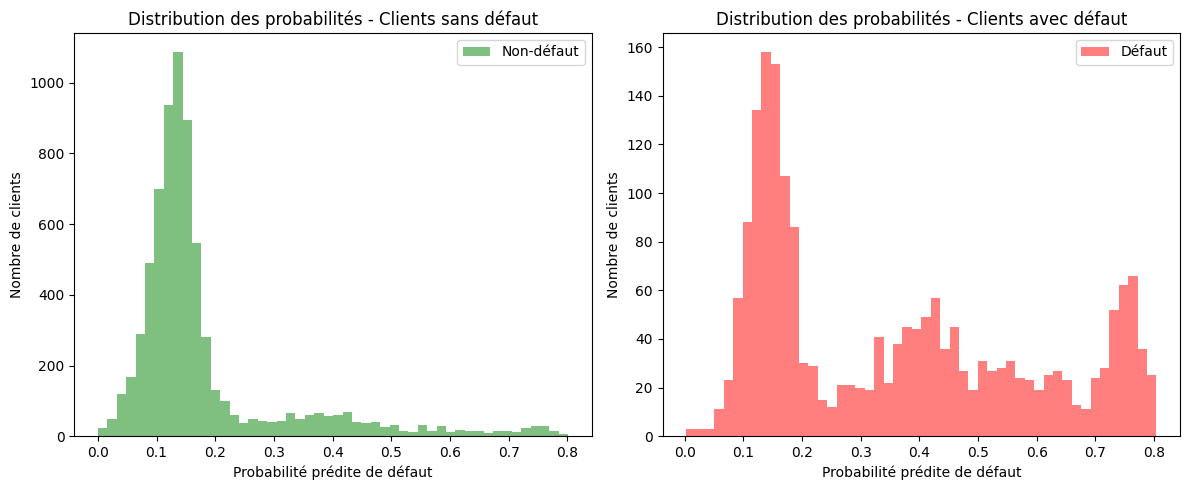

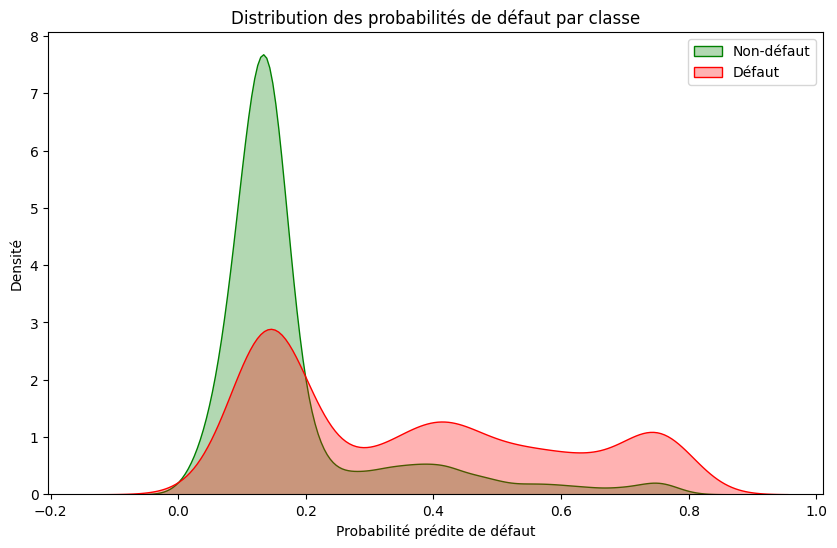

In [17]:
# Créer deux distributions séparées pour les défauts et non-défauts
plt.figure(figsize=(12, 5))

# Distribution des probabilités prédites pour les non-défauts (y=0)
plt.subplot(1, 2, 1)
plt.hist(y_test_pred[y_test == 0], bins=50, alpha=0.5, color='green', label='Non-défaut')
plt.xlabel('Probabilité prédite de défaut')
plt.ylabel('Nombre de clients')
plt.title('Distribution des probabilités - Clients sans défaut')
plt.legend()

# Distribution des probabilités prédites pour les défauts (y=1)
plt.subplot(1, 2, 2)
plt.hist(y_test_pred[y_test == 1], bins=50, alpha=0.5, color='red', label='Défaut')
plt.xlabel('Probabilité prédite de défaut')
plt.ylabel('Nombre de clients')
plt.title('Distribution des probabilités - Clients avec défaut')
plt.legend()

plt.tight_layout()
plt.show()
# Tracer les courbes de densité de probabilité sur le même graphique
plt.figure(figsize=(10, 6))

# Densité pour les non-défauts (y=0)
sns.kdeplot(data=y_test_pred[y_test == 0], color='green', label='Non-défaut', fill=True, alpha=0.3)

# Densité pour les défauts (y=1)
sns.kdeplot(data=y_test_pred[y_test == 1], color='red', label='Défaut', fill=True, alpha=0.3)

plt.xlabel('Probabilité prédite de défaut')
plt.ylabel('Densité')
plt.title('Distribution des probabilités de défaut par classe')
plt.legend()
plt.show()

**Commentaires sur les modèles : 
Les AUC des 2 modèles sont de 75% et 76%, ce qui montre une assez bonne capacité de prédiction du modèle
Les valeurs des métriques (accuracy, précision...) sont assez proches donc le modèle se généralise bien au données de test
Pour pouvoir évaluer le pouvoir disciminant du modèle on analyse les courbes de densité des données prédites entre les défauts et les non défaut. On constate que ces 2 courbes se chevauchent. Il convient d'améliorer davantage les performances du modèle afin d'avoir une meilleure discrimination entre les positifs et les négatifs

## Amélioration du modèle

Discrétisation des variables + sélection des variables

In [18]:
#La fontion ci-dessous permet d'effectuer un découpage sur les variables quantitatives qui permette de maximiser le V de Cramer entre la variable redécoupée et la variable à prédire

def find_optimal_bins(X, y, variable, max_bins=5):
    """
    Trouve le nombre optimal de bins pour discrétiser une variable.
    """
    def calculate_cramer_v(table):
        chi2 = chi2_contingency(table)[0]
        n = table.to_numpy().sum()
        min_dim = min(table.shape) - 1
        return np.sqrt(chi2 / (n * min_dim)) if n > 0 and min_dim > 0 else 0

    results = []

    for n_bins in range(2, max_bins + 1):
        # Calcul des quantiles et suppression des doublons dans les bornes
        boundaries = np.unique(np.percentile(X[variable], np.linspace(0, 100, n_bins + 1)))

        # Si le nombre de bornes uniques est insuffisant, passer à l'itération suivante
        if len(boundaries) < 3:
            continue

        try:
            X_binned = pd.cut(
                X[variable],
                bins=boundaries,
                labels=False,
                include_lowest=True,  # Assure l'inclusion de la valeur minimale
                duplicates='drop'
            )
            contingency = pd.crosstab(X_binned, y)
            cramer = calculate_cramer_v(contingency)

            results.append({
                'n_bins': len(boundaries) - 1,
                'cramer_v': cramer,
                'boundaries': boundaries
            })
        except Exception as e:
            print(f"Erreur avec {n_bins} bins pour {variable}: {e}")
            continue

    if not results:
        # Si aucune discrétisation n'a fonctionné, retourner la variable d'origine
        return X[variable]

    # Sélection du meilleur nombre de bins selon le maximum de Cramér's V
    best_bins = max(results, key=lambda x: x['cramer_v'])

    # Discrétisation avec le meilleur nombre de bins
    X_discretized = pd.cut(
        X[variable],
        bins=best_bins['boundaries'],
        include_lowest=True,  # Assure l'inclusion de la valeur minimale
        duplicates='drop'
    )

    return X_discretized

In [19]:
# Liste des variables quantitatives
quant_vars = ['LIMIT_BAL', 'AGE',
              'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
              'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


# Liste des variables qualitatives (toutes les colonnes sauf les quantitatives)
qual_vars = [col for col in X.columns if col not in quant_vars]

# Création du nouveau DataFrame
X_transformed = X[qual_vars].copy()

# Discrétisation de chaque variable quantitative
for var in quant_vars:
    X_transformed[f'{var}_disc'] = find_optimal_bins(X, y, var, max_bins=5)

# Ajout de la variable cible
X_transformed['DEFAULT'] = y

print("Aperçu du DataFrame transformé:")
print(X_transformed.head())


Aperçu du DataFrame transformé:
   SEX EDUCATION MARRIAGE         PAY_0         PAY_2     PAY_3     PAY_4  \
0    2         2        1  Late_payment  Late_payment  Pay_duly  Pay_duly   
1    2         2        2      Pay_duly  Late_payment  Pay_duly  Pay_duly   
2    2         2        2      Pay_duly      Pay_duly  Pay_duly  Pay_duly   
3    2         2        1      Pay_duly      Pay_duly  Pay_duly  Pay_duly   
4    1         2        1      Pay_duly      Pay_duly  Pay_duly  Pay_duly   

      PAY_5         PAY_6       LIMIT_BAL_disc  ...        BILL_AMT4_disc  \
0  Pay_duly      Pay_duly  (9999.999, 50000.0]  ...  (-170000.001, 988.0]   
1  Pay_duly  Late_payment  (50000.0, 140000.0]  ...      (988.0, 11145.0]   
2  Pay_duly      Pay_duly  (50000.0, 140000.0]  ...    (11145.0, 28604.4]   
3  Pay_duly      Pay_duly  (9999.999, 50000.0]  ...    (11145.0, 28604.4]   
4  Pay_duly      Pay_duly  (9999.999, 50000.0]  ...    (11145.0, 28604.4]   

        BILL_AMT5_disc        BILL_AMT6_di

# Calcul des IV pour chaque variable

Information Value (IV) - Un indicateur puissant pour la sélection de variables
L'Information Value (IV) est une mesure statistique très utilisée dans le domaine du crédit scoring et de l'analyse prédictive pour évaluer le pouvoir prédictif des variables explicatives par rapport à une variable cible binaire.

Pourquoi utiliser l'IV ?
Pouvoir prédictif : L'IV mesure la capacité d'une variable à distinguer entre deux classes (ex: défaut vs non-défaut)
Facilité d'interprétation : L'IV fournit une valeur unique qui permet de comparer directement les variables
Robustesse : Moins sensible aux outliers que d'autres métriques
Adaptée aux variables catégorielles : Particulièrement efficace pour évaluer les variables discrétisées
Comment interpréter l'IV ?
Valeur IV	Pouvoir prédictif	Recommandation
'< 0.02	Très faible	Ne pas utiliser la variable
'0.02 - 0.1	Faible	Pouvoir prédictif limité
'0.1 - 0.3	Moyen	Variable utile
'0.3 - 0.5	Fort	Variable très prédictive
'> 0.5	Très fort	Excellent prédicteur mais attention au surapprentissage

Formule de calcul
IV = Σ (% Bons - % Mauvais) × ln(% Bons / % Mauvais)

où :

% Bons = proportion d'observations de classe 0 dans la catégorie
% Mauvais = proportion d'observations de classe 1 dans la catégorie
Cette métrique nous aidera à sélectionner les variables les plus pertinentes pour notre modèle de scoring.

In [20]:
def calculate_iv_for_feature(df, feature, target='default'):
    """
    Calcule l'Information Value (IV) pour une variable.

    Args:
        df: DataFrame contenant les données
        feature: Nom de la variable à analyser
        target: Nom de la variable cible

    Returns:
        float: Information Value
        dict: Détails WoE par catégorie
    """
    # Création d'une table de contingence
    contingency = pd.crosstab(df[feature], df[target])

    # Calcul des proportions pour chaque classe
    prop_good = contingency[0] / contingency[0].sum()
    prop_bad = contingency[1] / contingency[1].sum()

    # Calcul de WoE et IV
    woe = np.log(prop_good / prop_bad)
    iv = ((prop_good - prop_bad) * woe).sum()

    # Création d'un dictionnaire des WoE par catégorie
    woe_dict = woe.to_dict()

    return iv, woe_dict

def calculate_iv_all_features(df, target='DEFAULT'):
    """
    Calcule l'IV pour toutes les variables du DataFrame.

    Args:
        df: DataFrame contenant les données
        target: Nom de la variable cible

    Returns:
        dict: IV scores pour chaque variable
        dict: WoE dictionnaires pour chaque variable
    """
    iv_scores = {}
    woe_dicts = {}

    for column in df.columns:
        if column != target:
            try:
                iv, woe_dict = calculate_iv_for_feature(df, column, target)
                iv_scores[column] = iv
                woe_dicts[column] = woe_dict
            except Exception as e:
                print(f"Erreur pour {column}: {e}")
                continue

    return iv_scores, woe_dicts


In [21]:
# Application sur les données discrétisées
print("Calcul des IV sur les données discrétisées...")
iv_scores, woe_dicts = calculate_iv_all_features(X_transformed)

# Tri des variables par IV décroissant
iv_scores = dict(sorted(iv_scores.items(), key=lambda x: x[1], reverse=True))

# Affichage des résultats
print("\nInformation Values pour chaque variable:")
for var, iv in iv_scores.items():
    print(f"{var}: {iv:.4f}")

Calcul des IV sur les données discrétisées...

Information Values pour chaque variable:
PAY_0: 0.6842
PAY_2: 0.5409
PAY_3: 0.4086
PAY_4: 0.3543
PAY_5: 0.3283
PAY_6: 0.2816
LIMIT_BAL_disc: 0.1601
PAY_AMT1_disc: 0.1548
PAY_AMT2_disc: 0.1395
PAY_AMT3_disc: 0.1168
PAY_AMT4_disc: 0.0940
PAY_AMT6_disc: 0.0899
PAY_AMT5_disc: 0.0760
EDUCATION: 0.0373
BILL_AMT6_disc: 0.0134
AGE_disc: 0.0126
BILL_AMT5_disc: 0.0125
BILL_AMT2_disc: 0.0103
BILL_AMT4_disc: 0.0102
BILL_AMT1_disc: 0.0102
BILL_AMT3_disc: 0.0095
SEX: 0.0092
MARRIAGE: 0.0054


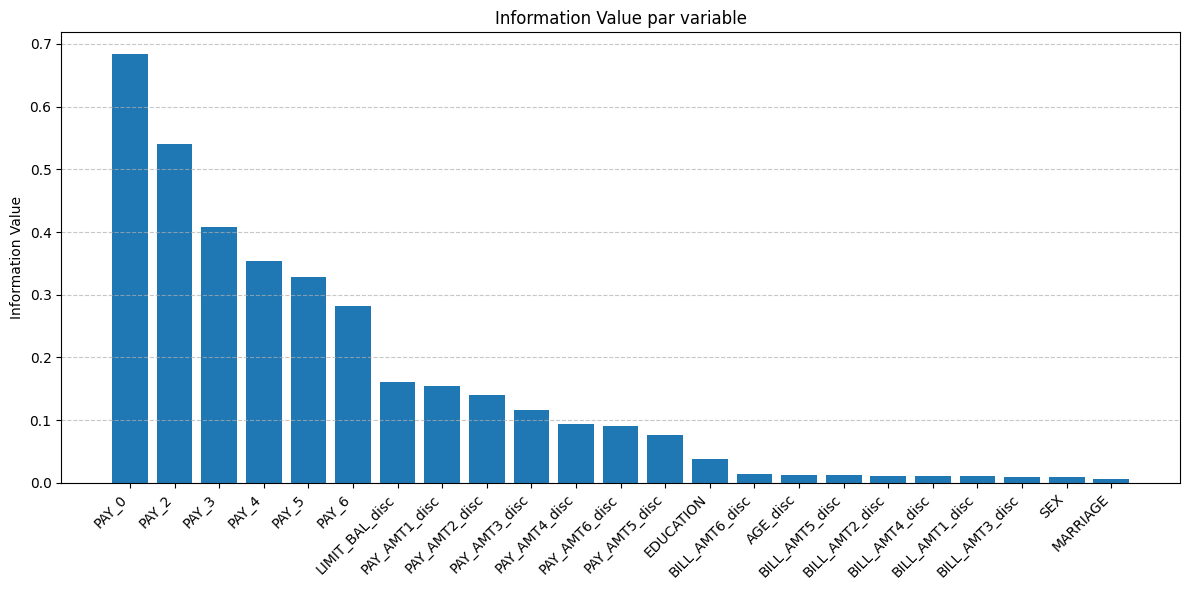


Weight of Evidence pour les variables les plus prédictives:

PAY_0:
  Late_payment: -1.2704
  Pay_duly: 0.5705

PAY_2:
  Late_payment: -1.4914
  Pay_duly: 0.3793

PAY_3:
  Late_payment: -1.3494
  Pay_duly: 0.3132

PAY_4:
  Late_payment: -1.4002
  Pay_duly: 0.2605

PAY_5:
  Late_payment: -1.4820
  Pay_duly: 0.2276


In [22]:
# Création d'un graphique des IV
plt.figure(figsize=(12, 6))
plt.bar(iv_scores.keys(), iv_scores.values())
plt.xticks(rotation=45, ha='right')
plt.title('Information Value par variable')
plt.ylabel('Information Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Affichage des WoE pour les variables les plus prédictives
top_features = list(iv_scores.keys())[:5]  # Top 5 variables
print("\nWeight of Evidence pour les variables les plus prédictives:")
for feature in top_features:
    print(f"\n{feature}:")
    for category, woe in woe_dicts[feature].items():
        print(f"  {category}: {woe:.4f}")

In [23]:
def calculate_cramers_v_matrix(df):
    """
    Calcule la matrice de liaison entre variables qualitatives avec le V de Cramer
    """
    # Identification des variables qualitatives (type object ou catégorie)
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Création d'une matrice vide
    n = len(categorical_cols)
    cramer_matrix = np.zeros((n, n))

    # Calcul du V de Cramer pour chaque paire de variables
    for i in range(n):
        for j in range(n):
            if i != j:
                # Création de la table de contingence
                confusion_matrix = pd.crosstab(df[categorical_cols[i]],
                                            df[categorical_cols[j]])

                # Calcul du chi2
                chi2, _ = chi2_contingency(confusion_matrix)[0:2]

                # Calcul du V de Cramer
                n_observations = confusion_matrix.sum().sum()
                min_dim = min(confusion_matrix.shape) - 1
                cramer_v = np.sqrt(chi2 / (n_observations * min_dim))

                cramer_matrix[i,j] = cramer_v

    # Création du DataFrame pour la visualisation
    cramer_df = pd.DataFrame(cramer_matrix,
                           index=categorical_cols,
                           columns=categorical_cols)

    return cramer_df


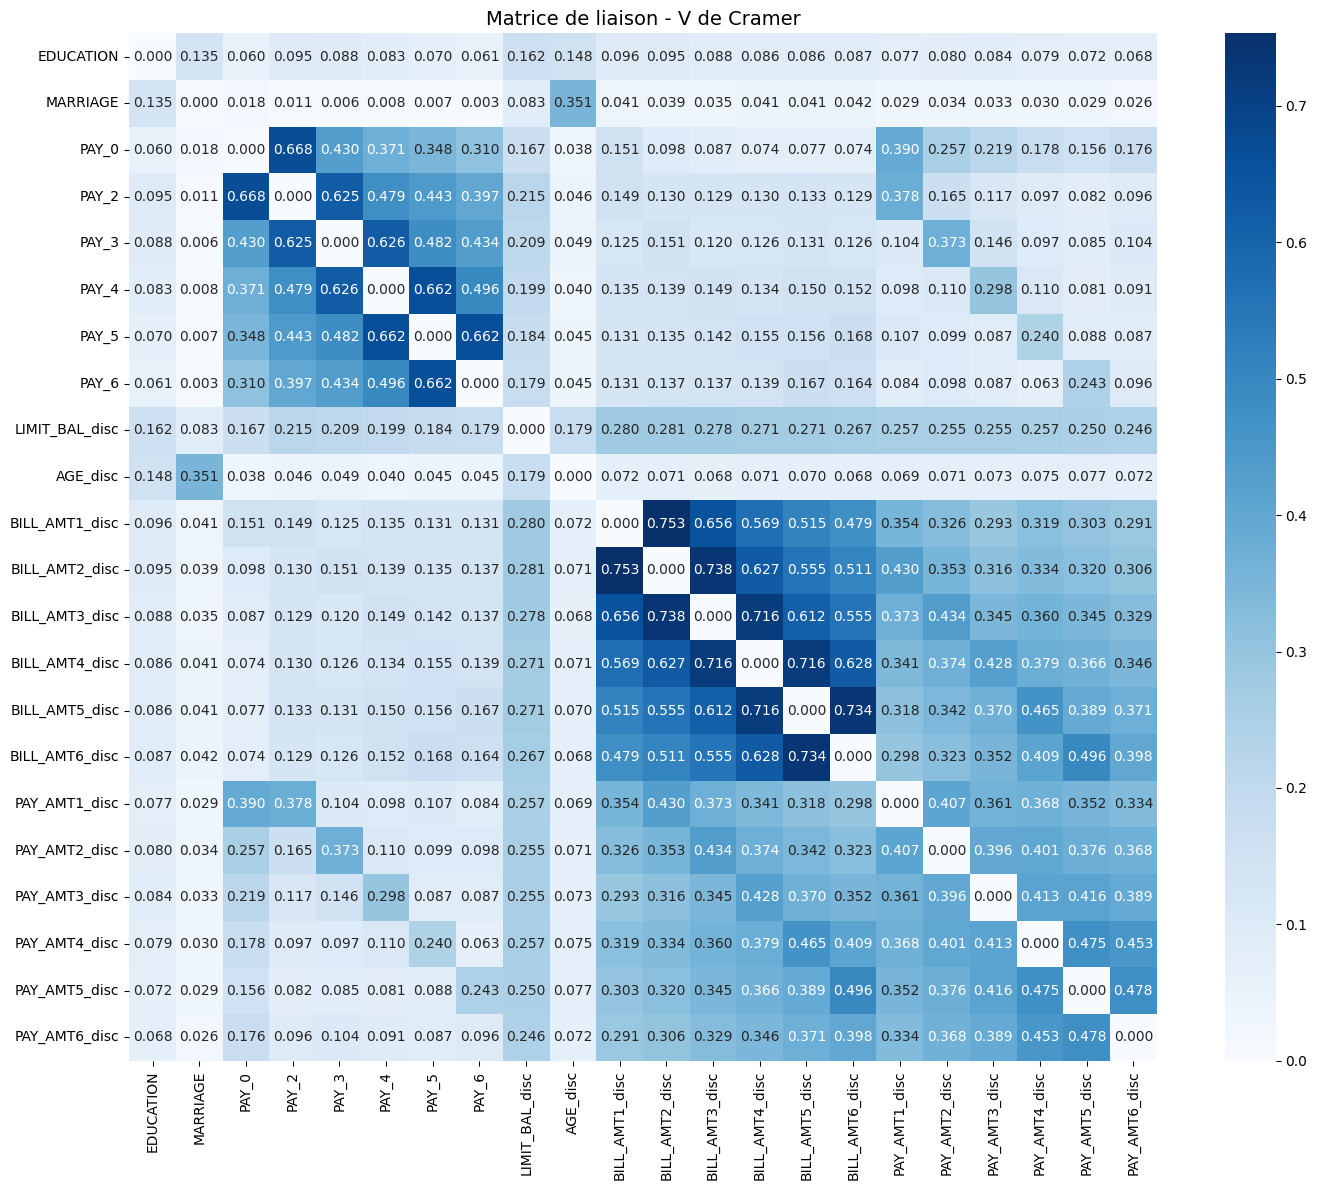


Paires de variables fortement liées (V de Cramer > 0.6):
--------------------------------------------------
PAY_0 <-> PAY_2: 0.668
PAY_2 <-> PAY_3: 0.625
PAY_3 <-> PAY_4: 0.626
PAY_4 <-> PAY_5: 0.662
PAY_5 <-> PAY_6: 0.662
BILL_AMT1_disc <-> BILL_AMT2_disc: 0.753
BILL_AMT1_disc <-> BILL_AMT3_disc: 0.656
BILL_AMT2_disc <-> BILL_AMT3_disc: 0.738
BILL_AMT2_disc <-> BILL_AMT4_disc: 0.627
BILL_AMT3_disc <-> BILL_AMT4_disc: 0.716
BILL_AMT3_disc <-> BILL_AMT5_disc: 0.612
BILL_AMT4_disc <-> BILL_AMT5_disc: 0.716
BILL_AMT4_disc <-> BILL_AMT6_disc: 0.628
BILL_AMT5_disc <-> BILL_AMT6_disc: 0.734


In [24]:
# Calcul de la matrice de liaison
cramer_matrix = calculate_cramers_v_matrix(X_transformed)

# Création de la heatmap avec une taille plus grande
plt.figure(figsize=(15, 12))
sns.heatmap(cramer_matrix,
            annot=True,
            cmap='Blues',
            fmt='.3f',
            square=True,
            annot_kws={'size': 10})
plt.title("Matrice de liaison - V de Cramer", fontsize=14)
plt.tight_layout()
plt.show()

# Identification des paires de variables fortement liées (V de Cramer > 0.6)
print("\nPaires de variables fortement liées (V de Cramer > 0.6):")
print("-" * 50)
for i in range(len(cramer_matrix.index)):
    for j in range(i+1, len(cramer_matrix.columns)):
        if cramer_matrix.iloc[i,j] > 0.6:
            print(f"{cramer_matrix.index[i]} <-> {cramer_matrix.columns[j]}: {cramer_matrix.iloc[i,j]:.3f}")


In [25]:
# Sélection des variables pour le modèle final

variables_selectionnees = [
    'SEX',            # Genre
    'MARRIAGE',       # Statut marital
    'PAY_0',         # Historique de paiement du mois actuel
    'LIMIT_BAL_disc', # Limite de crédit (version discrétisée)
    'BILL_AMT1_disc', # Montant de la facture du mois actuel (version discrétisée)
    'PAY_AMT1_disc',  # Montant payé le mois dernier (version discrétisée)
    'AGE_disc'        # Age du client (version discrétisée)
]

# Création du DataFrame avec les variables sélectionnées
X_final = X_transformed[variables_selectionnees]

# Préparation des données pour la modélisation finale
# Création des variables indicatrices pour toutes les variables qualitatives
X_final_encoded = pd.get_dummies(X_final, drop_first=True)
# Pour y, si ce n'est pas déjà numérique :
y_numeric = pd.to_numeric(y, errors='coerce')

# Conversion explicite de toutes les colonnes en int
for col in X_final_encoded.columns:
    X_final_encoded[col] = X_final_encoded[col].astype(int)

# Conversion de y en int
y = y.astype(int)


In [26]:

# Division en ensembles d'entraînement et de test avec stratification
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final_encoded,
    y_numeric,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [27]:

# Création et entraînement du modèle avec statsmodels
model_final = sm.Logit(y_train_final, X_train_final)
results = model_final.fit()


Optimization terminated successfully.
         Current function value: 0.457638
         Iterations 6


In [28]:

# Affichage du résumé statistique
print("\nRésumé statistique du modèle:")
print(results.summary())

# Création d'un DataFrame avec les coefficients et statistiques
coef_summary = pd.DataFrame({
    'Coefficient': results.params,
    'Std Error': results.bse,
    'z-value': results.tvalues,
    'P-value': results.pvalues,
    'CI 2.5%': results.conf_int()[0],
    'CI 97.5%': results.conf_int()[1]
})
print("\nTableau détaillé des coefficients:")



Résumé statistique du modèle:
                           Logit Regression Results                           
Dep. Variable:                DEFAULT   No. Observations:                24000
Model:                          Logit   Df Residuals:                    23981
Method:                           MLE   Df Model:                           18
Date:                Wed, 26 Mar 2025   Pseudo R-squ.:                  0.1340
Time:                        19:09:02   Log-Likelihood:                -10983.
converged:                       True   LL-Null:                       -12682.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
SEX                                     -0.0055      0.027     -0.204      0.838      -0.058       0.047
MARRIAGE_2            

In [29]:
print(coef_summary)

                                      Coefficient  Std Error    z-value  \
SEX                                     -0.005494   0.026899  -0.204254   
MARRIAGE_2                              -0.053147   0.035532  -1.495722   
MARRIAGE_Other                          -0.085531   0.145891  -0.586266   
PAY_0_Pay_duly                          -1.737584   0.039275 -44.242008   
LIMIT_BAL_disc_(50000.0, 140000.0]      -0.183018   0.046962  -3.897115   
LIMIT_BAL_disc_(140000.0, 240000.0]     -0.528593   0.052705 -10.029175   
LIMIT_BAL_disc_(240000.0, 1000000.0]    -0.773161   0.057904 -13.352481   
BILL_AMT1_disc_(1892.8, 13469.2]         0.324863   0.053972   6.019110   
BILL_AMT1_disc_(13469.2, 37045.2]        0.167380   0.054424   3.075463   
BILL_AMT1_disc_(37045.2, 83421.2]        0.097781   0.058456   1.672735   
BILL_AMT1_disc_(83421.2, 964511.0]       0.463825   0.061503   7.541499   
PAY_AMT1_disc_(316.0, 1724.0]            0.092656   0.053195   1.741816   
PAY_AMT1_disc_(1724.0, 30


Évaluation sur l'ensemble d'entraînement:
Métriques sur l'ensemble train:
Accuracy: 0.80, Precision: 0.59, Recall: 0.31, F1: 0.41

Matrice de Confusion (tableau):
             Prédiction Négatif (0)  Prédiction Positif (1)
Négatif (0)                   17526                    1165
Positif (1)                    3637                    1672


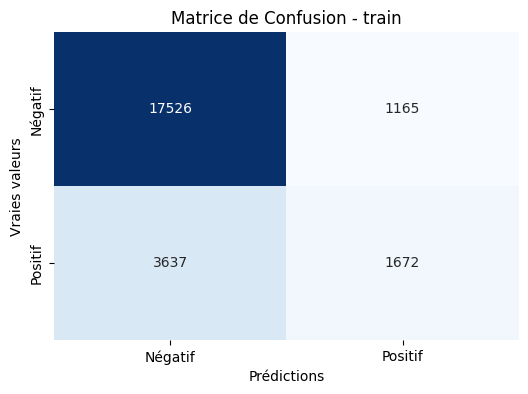

AUC: 0.73


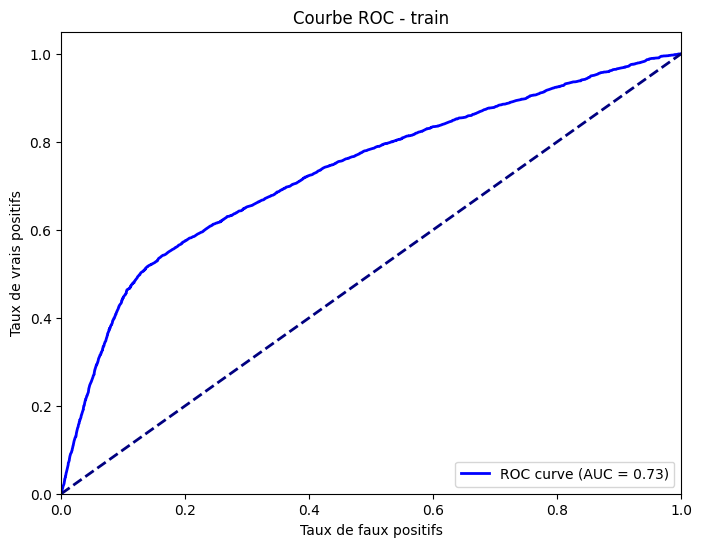


Évaluation sur l'ensemble de test:
Métriques sur l'ensemble test:
Accuracy: 0.79, Precision: 0.54, Recall: 0.29, F1: 0.38

Matrice de Confusion (tableau):
             Prédiction Négatif (0)  Prédiction Positif (1)
Négatif (0)                    4346                     327
Positif (1)                     940                     387


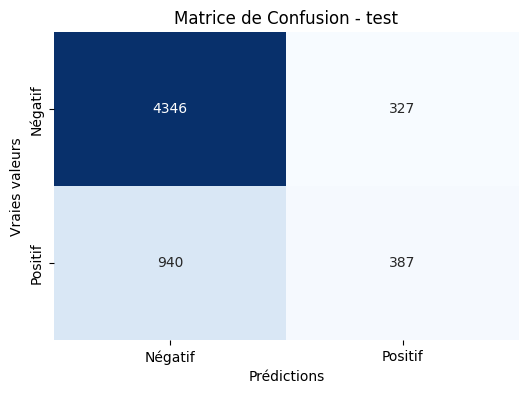

AUC: 0.71


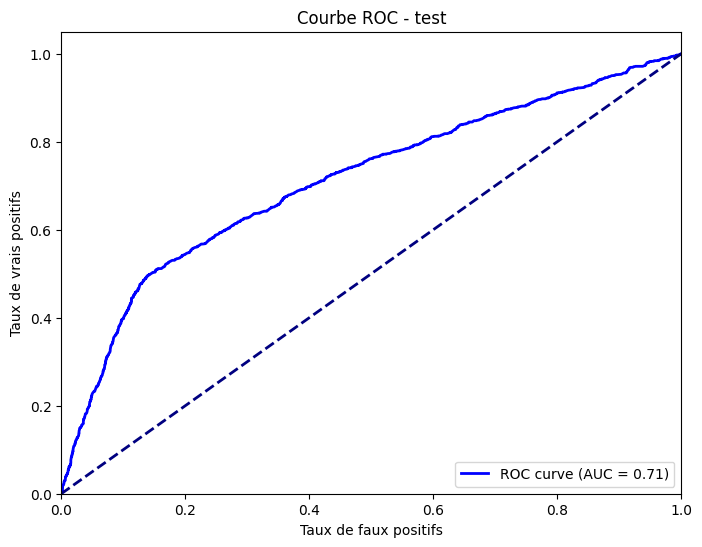

In [30]:
# Prédictions sur l'ensemble d'entraînement
y_train_pred_proba = results.predict(X_train_final)
print("\nÉvaluation sur l'ensemble d'entraînement:")
evaluer_performance(y_train_final, y_train_pred_proba, set_name="train")

# Prédictions sur l'ensemble de test
y_test_pred_proba = results.predict(X_test_final)
print("\nÉvaluation sur l'ensemble de test:")
evaluer_performance(y_test_final, y_test_pred_proba, set_name="test")

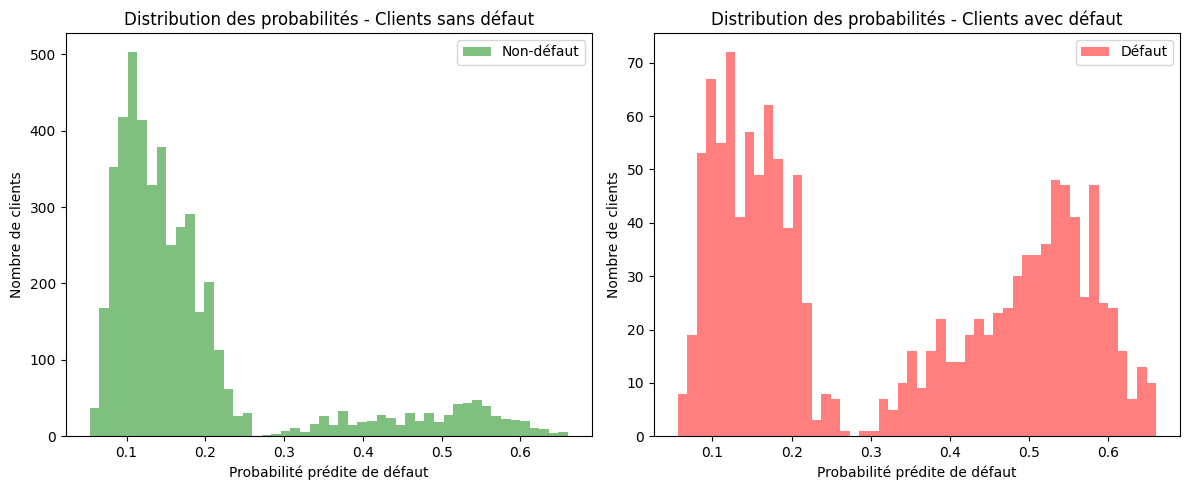

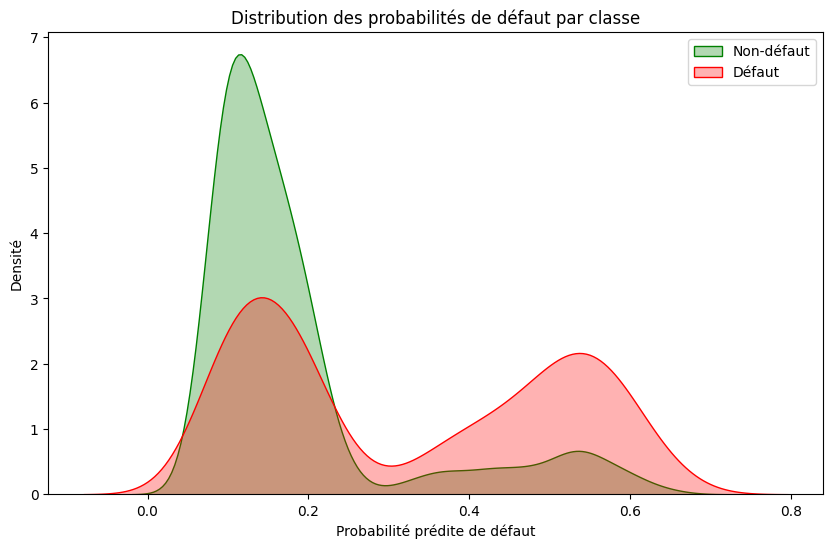

In [31]:

# Distribution des probabilités prédites
plt.figure(figsize=(12, 5))

# Distribution pour les non-défauts (y=0)
plt.subplot(1, 2, 1)
plt.hist(y_test_pred_proba[y_test_final == 0], bins=50, alpha=0.5, color='green', label='Non-défaut')
plt.xlabel('Probabilité prédite de défaut')
plt.ylabel('Nombre de clients')
plt.title('Distribution des probabilités - Clients sans défaut')
plt.legend()

# Distribution pour les défauts (y=1)
plt.subplot(1, 2, 2)
plt.hist(y_test_pred_proba[y_test_final == 1], bins=50, alpha=0.5, color='red', label='Défaut')
plt.xlabel('Probabilité prédite de défaut')
plt.ylabel('Nombre de clients')
plt.title('Distribution des probabilités - Clients avec défaut')
plt.legend()

plt.tight_layout()
plt.show()

# Courbes de densité
plt.figure(figsize=(10, 6))
sns.kdeplot(data=y_test_pred_proba[y_test_final == 0], color='green', label='Non-défaut', fill=True, alpha=0.3)
sns.kdeplot(data=y_test_pred_proba[y_test_final == 1], color='red', label='Défaut', fill=True, alpha=0.3)
plt.xlabel('Probabilité prédite de défaut')
plt.ylabel('Densité')
plt.title('Distribution des probabilités de défaut par classe')
plt.legend()
plt.show()